# Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 


In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [2]:
df = pd.read_csv(data)

In [5]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
#check for missing values
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [ ]:
#Get categorial columns
cat_columns = list(df.select_dtypes(include=['object']).columns)

#Get numerical columns list
num_columns = list(df.select_dtypes(include=['int64', 'float64']).columns)


#replace missing values in categorial columns with 'NA'
for col in cat_columns:
    df[col] = df[col].fillna('NA')

#replace missing values in numerical columns with 0.0
for col in num_columns:
    df[col] = df[col].fillna(0.0)
    
#check for missing values again
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [7]:
#Split the data to train/val/test
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

#reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#set target variable
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

#drop target variable from dataframes
df_train = df_train.drop('converted', axis=1)
df_val = df_val.drop('converted', axis=1)
df_test = df_test.drop('converted', axis=1)

#check the shape of the datasets
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)


(876, 8)
(293, 8)
(293, 8)


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [ ]:
#roc auc feature importance of numerical features, use each numerrical variable to predict the target variable
from sklearn.metrics import roc_auc_score

#create list of numerical columns withouth converted
num_columns.remove('converted')

#if auc is <0.5 invert by using - in front of the variable
for col in num_columns:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    print(f'ROC AUC for {col}: {auc}')

ROC AUC for number_of_courses_viewed: 0.7635680590007088
ROC AUC for annual_income: 0.5519578313253012
ROC AUC for interaction_count: 0.738270176293409
ROC AUC for lead_score: 0.6144993577250176


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [12]:
#apply one hot encoding to categorical variables using DictVectorizer and train a logistic regression model
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

#create feature list
categorical = cat_columns.copy()
numerical = num_columns.copy()
features = categorical + numerical

#create pipeline
dv = DictVectorizer(sparse=False)
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

#train the model
train_dicts = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

#fit the model
lr.fit(X_train, y_train)
val_dicts = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dicts)

#predict probabilities on validation set
y_pred = lr.predict_proba(X_val)[:, 1]

#calculate roc auc on validation set
auc = roc_auc_score(y_val, y_pred)

#print the auc score to 3 decimal places
print(f'ROC AUC on validation set: {auc:.3f}')

ROC AUC on validation set: 0.817


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

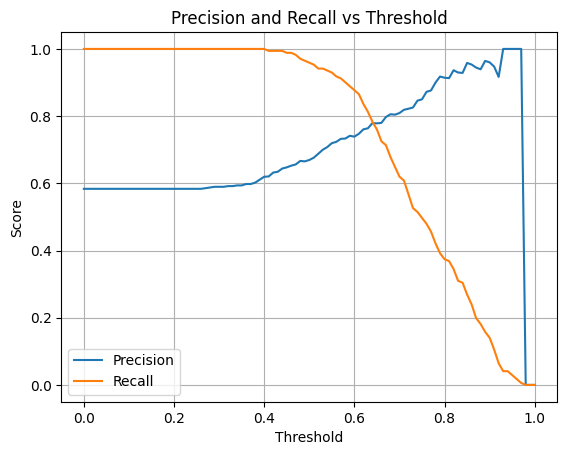

Precision and Recall are equal at threshold 0.64: 0.779
Precision and Recall are equal at threshold 0.98: 0.000
Precision and Recall are equal at threshold 0.99: 0.000
Precision and Recall are equal at threshold 1.00: 0.000


In [19]:
#compute precision and recall at all thresholds from 0.0 to 1.0 with step 0.01 for each threshold, and plot precision and recall as a function of the threshold
from sklearn.metrics import precision_recall_curve

#thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

#for each threshold, compute precision and recall
precisions = []
recalls = []
for t in thresholds:
    y_pred_threshold = (y_pred >= t).astype(int)
    tp = ((y_val == 1) & (y_pred_threshold == 1)).sum()
    fp = ((y_val == 0) & (y_pred_threshold == 1)).sum()
    fn = ((y_val == 1) & (y_pred_threshold == 0)).sum()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precisions.append(precision)
    recalls.append(recall)

#plot precision and recall as a function of the threshold
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

#atwhat threshold precision and recall are equal
for t, p, r in zip(thresholds, precisions, recalls):
    if abs(p - r) < 0.01:
        print(f'Precision and Recall are equal at threshold {t:.2f}: {p:.3f}')


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [18]:
#compute f1 at all thresholds from 0.0 to 1.0 with step 0.01, and plot f1 as a function of the threshold
from sklearn.metrics import f1_score

f1_scores = []
thresholds = np.arange(0.0, 1.01, 0.01)
for threshold in thresholds:
    y_pred_threshold = (y_pred >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred_threshold)
    f1_scores.append(f1)
#find the threshold that gives the highest f1 score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
print(f'Best threshold: {best_threshold:.2f}')
print(f'Best F1 score: {best_f1:.3f}')

Best threshold: 0.57
Best F1 score: 0.812


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [20]:
#use kflold cross validation with 5 folds to evaluate the model
from sklearn.model_selection import KFold

#initialize kfold
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []
#iterate through the folds of df_full_train
for train_index, val_index in kf.split(df_full_train):
    df_train_kf = df_full_train.iloc[train_index]
    df_val_kf = df_full_train.iloc[val_index]
    
    y_train_kf = df_train_kf.converted.values
    y_val_kf = df_val_kf.converted.values
    
    df_train_kf = df_train_kf.drop('converted', axis=1)
    df_val_kf = df_val_kf.drop('converted', axis=1)
    
    train_dicts_kf = df_train_kf[features].to_dict(orient='records')
    X_train_kf = dv.fit_transform(train_dicts_kf)
    
    lr.fit(X_train_kf, y_train_kf)
    
    val_dicts_kf = df_val_kf[features].to_dict(orient='records')
    X_val_kf = dv.transform(val_dicts_kf)
    
    y_pred_kf = lr.predict_proba(X_val_kf)[:, 1]
    
    auc_kf = roc_auc_score(y_val_kf, y_pred_kf)
    auc_scores.append(auc_kf)

    #calculate the mean and std of the auc scores
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
print(f'Mean ROC AUC: {mean_auc:.3f}')
print(f'STD ROC AUC: {std_auc:.3f}')

Mean ROC AUC: 0.822
STD ROC AUC: 0.036


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [22]:
#use 5fold cross validation to find the best regularization parameter C for logistic regression from the list [0.000001, 0.001, 1]
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
C_values = [0.000001, 0.001, 1]
best_C = None
best_mean_auc = 0
for C in C_values:
    auc_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    for train_index, val_index in kf.split(df_full_train):
        df_train_kf = df_full_train.iloc[train_index]
        df_val_kf = df_full_train.iloc[val_index]
        
        y_train_kf = df_train_kf.converted.values
        y_val_kf = df_val_kf.converted.values
        
        df_train_kf = df_train_kf.drop('converted', axis=1)
        df_val_kf = df_val_kf.drop('converted', axis=1)
        
        train_dicts_kf = df_train_kf[features].to_dict(orient='records')
        X_train_kf = dv.fit_transform(train_dicts_kf)
        
        lr = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        lr.fit(X_train_kf, y_train_kf)
        
        val_dicts_kf = df_val_kf[features].to_dict(orient='records')
        X_val_kf = dv.transform(val_dicts_kf)
        
        y_pred_kf = lr.predict_proba(X_val_kf)[:, 1]
        
        auc_kf = roc_auc_score(y_val_kf, y_pred_kf)
        auc_scores.append(auc_kf)
#find c value with the highest mean auc if ties chose one with lowest std
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    print(f'C={C}: Mean ROC AUC={mean_auc:.3f}, STD ROC AUC={std_auc:.3f}')
    if mean_auc > best_mean_auc or (mean_auc == best_mean_auc and (best_C is None or std_auc < best_std_auc)):
        best_mean_auc = mean_auc
        best_std_auc = std_auc
        best_C = C
print(f'Best C: {best_C}')  

C=1e-06: Mean ROC AUC=0.560, STD ROC AUC=0.024
C=0.001: Mean ROC AUC=0.867, STD ROC AUC=0.029
C=1: Mean ROC AUC=0.822, STD ROC AUC=0.036
Best C: 0.001


## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
* If your answer doesn't match options exactly, select the closest one